In [1]:
import sys
import numpy as np
import itertools
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
#from pyFORC_log import Fit

In [14]:


class dataLoad_tf(object):
    '''
    #=================================================
    /process the measured forc data.
    /converte the raw data into matrix
    /with x range and y range
    /empty postion replaced with np.nan
    #=================================================
    '''
    def __init__(self,fileAdres=None):
        self.rawData(fileAdres)
        self.matrix()

    def rawData(self,fileAdres=None):
        #skip skiprows
        skip_from = '    Field         Moment   '
        with open(fileAdres,'rb') as fr:
            for i,line in enumerate(fr,1):
                if skip_from in str(line):
                    skiprows=i+1
                    break
                else:
                    pass
        skiprows = skiprows if isinstance(skiprows,int) else 1
        df = pd.read_csv(fileAdres, skiprows=skiprows, sep='\s+',
                         delimiter=',', names=['H','M'], skipfooter=1,
                         engine='python',
                         skip_blank_lines=False,
                         dtype=np.float)

        #print(df.iloc[12:33])

        rows = len(df.index)
       
        seg_index=[]
        for index,row in df.iterrows():
            if index<rows-2  and np.isnan(row['H']) and np.isnan(df.loc[index+2]['H']):
                seg_index.append(index+1)


        H_tf_seg,H_rem_seg,M_tf_seg,M_rem_seg = [],[],[],[]
        tf_a,tf_b,tf_m = [],[],[]
        rem_a,rem_b,rem_m = [],[],[]
        in_m = []
        #h_a,h_b,h_m=[[],[],[]]

        for i in np.arange(len(seg_index)-1):
            df_seg = df.iloc[seg_index[i]:seg_index[i+1]+1]
            #print(df_seg.index)
            points = ((seg_index[i+1]+1 - seg_index[i])/3 - 1)/2
            #print(points)
            for j in np.arange(points):
                H_tf_seg.append(df_seg.loc[seg_index[i]+5+j*6]['H'])
                M_tf_seg.append(df_seg.loc[seg_index[i]+5+j*6]['M'])

                H_rem_seg.append(df_seg.loc[seg_index[i]+5+j*6]['H'])
                M_rem_seg.append(df_seg.loc[seg_index[i]+8+j*6]['M'])

            #print (H_tf_seg,H_rem_seg,M_tf_seg,M_rem_seg)
            for j in np.arange(points,dtype=np.int):
                tf_a.append(H_tf_seg[j])
                tf_b.append(H_tf_seg[0])
                tf_m.append(M_tf_seg[j])

                rem_a.append(H_rem_seg[j])
                rem_b.append(H_rem_seg[0])
                rem_m.append(M_rem_seg[j])

                in_m.append(M_tf_seg[j]-M_rem_seg[j])

            H_tf_seg,H_rem_seg,M_tf_seg,M_rem_seg = [],[],[],[]

        self.x = tf_a
        self.y = tf_b
        self.z = in_m


    def matrix(self):
        '''
        #=================================================
        transfer the data set to matrix as len(x)*len(y) with z value
        :return:
        #=================================================
        '''

        #X = np.linspace(np.min(self.x),np.max(self.x),200)
        #Y = np.linspace(np.min(self.y),np.max(self.y),200)
        xi,yi = np.mgrid[np.min(self.x):np.max(self.x):50j,np.min(self.y):np.max(self.y):50j]
        
        #xi = np.array([self.x,]*len(self.x)).transpose()
        #yi = np.array([self.y,]*len(self.y))

        self.x_range=[i[0] for i in xi]
        self.y_range=yi[0]
        zi=griddata((self.x,self.y),self.z/np.max(self.z),(xi,yi),method='linear')
        self.matrix_z = zi
        
        self.x_range=[i[0] for i in xi]
        self.y_range=yi[0]
        '''
        x1 = np.logspace(-3,np.log10(np.max(self.x)),num=100)
        x2 = -1*x1
        x = np.concatenate([x2[::-1],x1])
        xi = np.array([x,]*200).transpose()
        #print(x1)
        y1 = np.logspace(-3,np.log10(np.max([np.max(self.y),abs(np.min(self.y))])),num=100)
        y2 = -1*y1
        y = np.concatenate([y2[::-1],y1])
        yi = np.array([y,]*200)
        #print(yi)
        '''

        #xt,yi = np.mgrid[-0.159:0.159:200j,-0.159:0.133:200j]


        #zi=griddata((self.x,self.y),self.z,(xi,yi),method='linear')
        #self.matrix_z = zi
        
        #print(zi[:,8])
        #print(np.count_nonzero(np.isnan(zi[:,8])))
        #print(self.x_range[8:-1])
        
        f = np.polyfit(self.x_range[8:-1],zi[:,8][8:-1],3)
        fx = np.poly1d(f)
        
        #print(fx(self.x_range[9]))
        
        #zi[1,4] = fx(self.y_range[2])
        
        
        for m in np.arange(0,len(xi)):
            #print(m)
            xarray = zi[:,m]
            xnum = np.count_nonzero(np.isnan(zi[:,m]))-1
            f = np.polyfit(self.x_range[xnum:-1],zi[:,m][xnum:-1],1)
            fx = np.poly1d(f)
            for j in np.arange(2,10,step=1):
                if xnum-j >0:
                    zi[xnum-j,m] = fx(self.x_range[xnum-j])
        
        
        
        #print(len(self.x))
        
        print(zi[:,1])
        
        
        
        plt.scatter(xi,yi,c=zi)#vmin=np.min(rho)-0.2)
        plt.show()

        
        



[        nan -0.96930268 -0.94984379 -0.93038489 -0.91061866 -0.88626587
 -0.86199265 -0.83752322 -0.80876375 -0.77999047 -0.74771175 -0.71398875
 -0.67698459 -0.63841069 -0.59619891 -0.5509758  -0.50313847 -0.45213939
 -0.39772054 -0.34025143 -0.28003509 -0.21804649 -0.1544637  -0.09139382
 -0.02997081  0.03011576  0.09266114  0.15574735  0.21818589  0.27928415
  0.33817608  0.39461067  0.44848927  0.49957514  0.54743934  0.59264003
  0.63520961  0.67474115  0.71115138  0.74550774  0.77780015  0.80719888
  0.83552098  0.86125596  0.88514132  0.90902245  0.9291113   0.9483755
  0.96763971         nan]


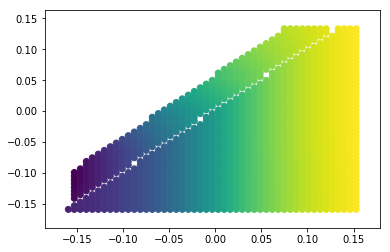

In [15]:
irdata = dataLoad_tf(fileAdres='../example/MSM33-60-1-d416_2.remforc')

In [352]:
class Fit(object):
    def __init__(self,irData=None,SF=None):
        '''
        #=================================================
        /process the raw data
        /do the fit
        #=================================================
        '''
        self.rawData = irData#dataLoad(fileAdres)
        #self.matrix_z,self.x_range,self.y_range=dataLoad(fileAdres).initial()
        if self.rawData !=None:
            self.fit(SF)
        else:
            pass
    def fit(self,SF=None):
        #SF=5
        #print(self.matrix_z.shape)
        #test
        self.test_fit(SF = SF, x_range = self.rawData.x_range, y_range = self.rawData.y_range,
                       matrix_z = self.rawData.matrix_z)
    def test_fit(self,SF, x_range, y_range, matrix_z):
        '''
        #=================================================
        /the main fitting process
        /xx,yy,zz = Hb,Ha,p
        /p is the FORC distribution
        /m0,n0 is the index of values on Ha = Hb
        /then loop m0 and n0
        /based on soomth factor(SF)
        /select data grid from the matrix_z for curve fitting
        #=================================================
        '''
        xx,yy,zz=[],[],[]
        m0,n0 = [],[]
        #for m in np.arange(0,len(x_range),step=6):
        #    for n in np.arange(0,len(y_range)):

        #for m,n in itertools.product(np.arange(0,len(x_range),step=5),np.arange(0,len(y_range))):
        #    a_=float(x_range[m]) # = Ha
        #    b_=float(y_range[n]) # = Hb
        #    if abs(a_-b_) < 0.001: # Ha nearly equal Hb
        #        m0.append(m)
        #        n0.append(n)

        #for m in m0:
        #    for n in n0:
        #for m,n in itertools.product(m0,n0):
        for m,n in itertools.product(np.arange(len(x_range),step=SF),np.arange(len(y_range),step=SF)):
            if ~np.isnan(matrix_z.item(m,n)):

                #for s in [-1,0,1]: #forc to select data around
                try:
                    s=0
                    grid_data = []
                    a_ = x_range[m]
                    b_ = y_range[n]
                    #for i in np.arange(2*SF+1):
                    #    for j in np.arange(2*SF+1):
                    if ~np.isnan(matrix_z.item(m+SF,n+SF)) and ~np.isnan(matrix_z.item(m+SF,n-SF)):
                        for i,j in itertools.product(np.arange(-SF,SF,step=1), np.arange(-SF,SF,step=1)):
                            try:
                                grid_data.append([x_range[m+i],y_range[n+j],matrix_z.item(m+i,n+j)])
                            except Exception as e:
                                pass

                    #print(grid_data)
                    '''
                    #=================================================
                    /when SF = n
                    /data grid as (2*n+1)x(2*n+1)
                    /every grid produce on FORC distritution p
                    /the fitting use d2_func
                    /test_lmf for process data
                    #=================================================
                    '''
                    x,y,z = test_lmf(grid_data)
                    try:
                        p = d2_func(x,y,z)
                        #print(p)
                        xx.append((a_-b_)/2)
                        yy.append((a_+b_)/2)
                        zz.append(p)
                    except Exception as e:
                        #print(e)
                        pass
                except:
                    pass
        '''
        #=================================================
        /the data will be save as pandas dataframe
        /all the data with nan values will be delete be dropna()
        #=================================================
        '''
        print(zz)
        df = pd.DataFrame({'x':xx,'y':yy,'z':zz})
        #df = df.replace(0,np.nan)
        df = df.dropna()
        '''
        #=================================================
        /due to the space near Bc = zero
        /the Bi values when Bc <0.003 will be mirrored to -Bc
        #=================================================
        '''
        #df_negative = df[(df.x<0.003)].copy()
        #df_negative['x'] = df_negative['x'].apply(lambda x: x*-1)
        #df_negative.x = df_negative.x*-1
        #df = df.append(df_negative)
        #df = df.drop_duplicates(['x','y'])
        #df = df.sort_values('x')
        plt.scatter(df.x,df.y,c=df.z)
        plt.show()
        '''
        #=================================================
        /reset the Bc and Bi range by X,Y
        /use linear interpolate to obtain FORC distribution
        #=================================================
        '''
        #X = np.linspace(0,0.15,400)
        #Y = np.linspace(-0.1,0.1,400)
        self.xi,self.yi = np.mgrid[0:np.max(df.x):50j,np.min(df.y):np.max(df.y):50j]
        #self.xi,self.yi = np.mgrid[0:0.2:400j,-0.15:0.15:400j]
        z = df.z/np.max(df.z)
        z = np.asarray(z.tolist())
        #Z = matplotlib.mlab.griddata(df.x,df.y,z,X,Y,interp='linear')
        #matplotlib 2.2 was expiered
        #plt.scatter(df.x,df.y,c=z)
        #plt.show()
        self.Z = griddata((df.x,df.y),z,(self.xi,self.yi), method='cubic')
        '''
        #=================================================
        /if using log space for X,Y
        /the scipy.gridata has to be used
        #X = np.logspace(np.log10(0.001),np.log10(0.15),100)
        #Y = np.logspace(np.log10(np.min(yy)),np.log10(np.max(yy)),100)
        #X, Y = np.meshgrid(X,Y)
        #points = np.column_stack((df.x.tolist(), df.y.tolist()))
        #Z = griddata(points, z, (X,Y),method='linear')
        #print(Z)
        #=================================================
        '''
    def plot(self):
        fig = plt.figure(figsize=(6,5), facecolor='white')
        fig.subplots_adjust(left=0.18, right=0.97,
                        bottom=0.18, top=0.9, wspace=0.5, hspace=0.5)
        #ax = fig.add_subplot(1,1,1)
        plt.contour(self.xi*1000,self.yi*1000,self.Z,9,colors='k',linewidths=0.5)#mt to T
        #plt.pcolormesh(X,Y,Z_a,cmap=plt.get_cmap('rainbow'))#vmin=np.min(rho)-0.2)
        plt.pcolormesh(self.xi*1000,self.yi*1000,self.Z,cmap=plt.get_cmap('rainbow'))#vmin=np.min(rho)-0.2)
        plt.colorbar()
        #plt.xlim(0,0.15)
        #plt.ylim(-0.1,0.1)
        plt.xlabel('B$_{c}$ (mT)',fontsize=12)
        plt.ylabel('B$_{i}$ (mT)',fontsize=12)

        plt.show()


def d2_func(x, y, z):
    '''
    #=================================================
    /poly fit for every SF grid data
    #=================================================
    '''
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()
    A = np.array([np.ones(len(X)), X, X**2, Y, Y**2, X*Y]).T
    Z = np.array(z)
    B = Z.flatten()
    #print(A.shape,B.shape)
    coeff, r, rank, s = np.linalg.lstsq(A, B, rcond=None)
    return -coeff[5]

def test_lmf(data):
    '''
    #=================================================
    /process the grid data
    /convert to list data for poly fitting
    #=================================================
    '''
    a=[]
    b=[]
    M=[]
    for i in data:
        a.append(i[0]) #np.array([i[1] for i in data], dtype=np.float64)
        b.append(i[1])#np.array([i[0] for i in data], dtype=np.float64)
        M.append(i[2])#np.array([i[2] for i in data], dtype=np.float64)
    a = np.array(a, dtype=np.float64).tolist()
    b = np.array(b, dtype=np.float64).tolist()
    M = np.array(M, dtype=np.float64).tolist()
    a = list(set(a))
    b = list(set(b))
    #print(set(a),set(b))
    #print(a.shape,b.shape,M.shape)
    #params = [0.1,0.1,0.1,0.1,0.1,0.1]
    return a, b, M

[]


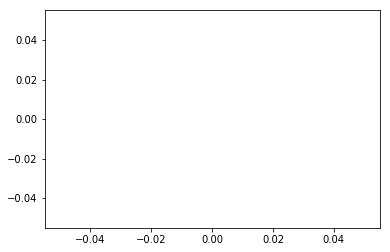

ValueError: No points given

In [353]:
Fit(irData=irdata,SF=3)